In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import socket
import sys
import copy

In [3]:
# Load external libraries
key = 'external_libs_path'
if socket.gethostname() == 'hughes-machine':
    external_libs_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
else:
    external_libs_path= '/storage/groups/ml01/code/andres.becker/master_thesis/workspace/libs'
print('External libs path: \n'+external_libs_path)

if not os.path.exists(external_libs_path):
    msg = 'External library path {} does not exist!'.format(external_libs_path)
    raise Exception(msg)

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, external_libs_path)

import Utils as utils


External libs path: 
/home/hhughes/Documents/Master_Thesis/Project/workspace/libs


In [4]:
# Load parameters
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Parameters/model_params/local/Quick_test_local.json'
#PARAMETERS_FILE = 'dont_touch_me-input_parameters_file'

# Open parameters
if os.path.exists(PARAMETERS_FILE):
    with open(PARAMETERS_FILE) as file:
        p = json.load(file)
else:
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))

# look for missing parameters and set default values
p['parameters_file_path'] = PARAMETERS_FILE
p['external_libs_path'] = external_libs_path
# check and set default parameters
p, info = utils.set_model_default_parameters(p)

In [5]:
# Load Channels file
with open(os.path.join(p['pp_path'], 'channels.csv')) as file:
    channels = pd.read_csv(file)

In [6]:
def get_top_score_map(score_map, cell_mask, percent):
    n_channels = score_map.shape[-1]
    n_pixels = n_channels * (score_map.shape[0]**2)

    cell_prop = np.sum(cell_mask) * n_channels / n_pixels
    top_percent = cell_prop * percent
    n_top_pixels = int(top_percent * n_pixels)
    # get top pixels
    boun_val = (-1 * np.sort(-1 * score_map, axis=None))[n_top_pixels]
    mask_tops = (score_map > boun_val)

    temp_score_map = copy.deepcopy(score_map)
    temp_score_map[~mask_tops] = 0
    
    return temp_score_map

In [7]:
sample_ids = ['337290']
#"_comment": "Path where the Score Maps are:-------------------------------",
score_maps_path = "/home/hhughes/Documents/Master_Thesis/Project/datasets/Score_Maps/BL/data"
pp_data_path = "/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_no_split/data"

## Load Dataset

In [8]:
# Path where tf datasets are
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

# Load the splits
#train_data, val_data = dataset['train'], dataset['validation']

In [28]:
metadata.splits

{'test_0': <tfds.core.SplitInfo num_examples=128>,
 'test_10': <tfds.core.SplitInfo num_examples=128>,
 'test_20': <tfds.core.SplitInfo num_examples=128>,
 'train_0': <tfds.core.SplitInfo num_examples=964>,
 'train_10': <tfds.core.SplitInfo num_examples=964>,
 'train_20': <tfds.core.SplitInfo num_examples=964>,
 'val_0': <tfds.core.SplitInfo num_examples=118>,
 'val_10': <tfds.core.SplitInfo num_examples=118>,
 'val_20': <tfds.core.SplitInfo num_examples=118>}

In [9]:
# Load degradated cells from TFDS
sample_cells = {}
for ds_key in [key for key in dataset.keys() if 'val' in key]:
    
    for cell in dataset[ds_key]:
        cell_id = cell['mapobject_id_cell'].numpy().decode()
        
        if cell_id in sample_ids:
            key = cell_id+'_'+ds_key.split("_")[1]
            sample_cells[key] = cell['image'].numpy()
            break

In [10]:
# Load score maps
sample_score_maps = {}
for cell_id in sample_ids:
    temp_path = os.path.join(score_maps_path, cell_id+'.npy')
    sample_score_maps[cell_id] = np.load(temp_path)

In [11]:
# Load cell mask
sample_cells_mask = {}
for cell_id in sample_ids:
    temp_path = os.path.join(pp_data_path, cell_id+'.npz')
    temp_cell = np.load(temp_path)
    sample_cells_mask[cell_id] = temp_cell['mask']

0.0
0.1


0.2


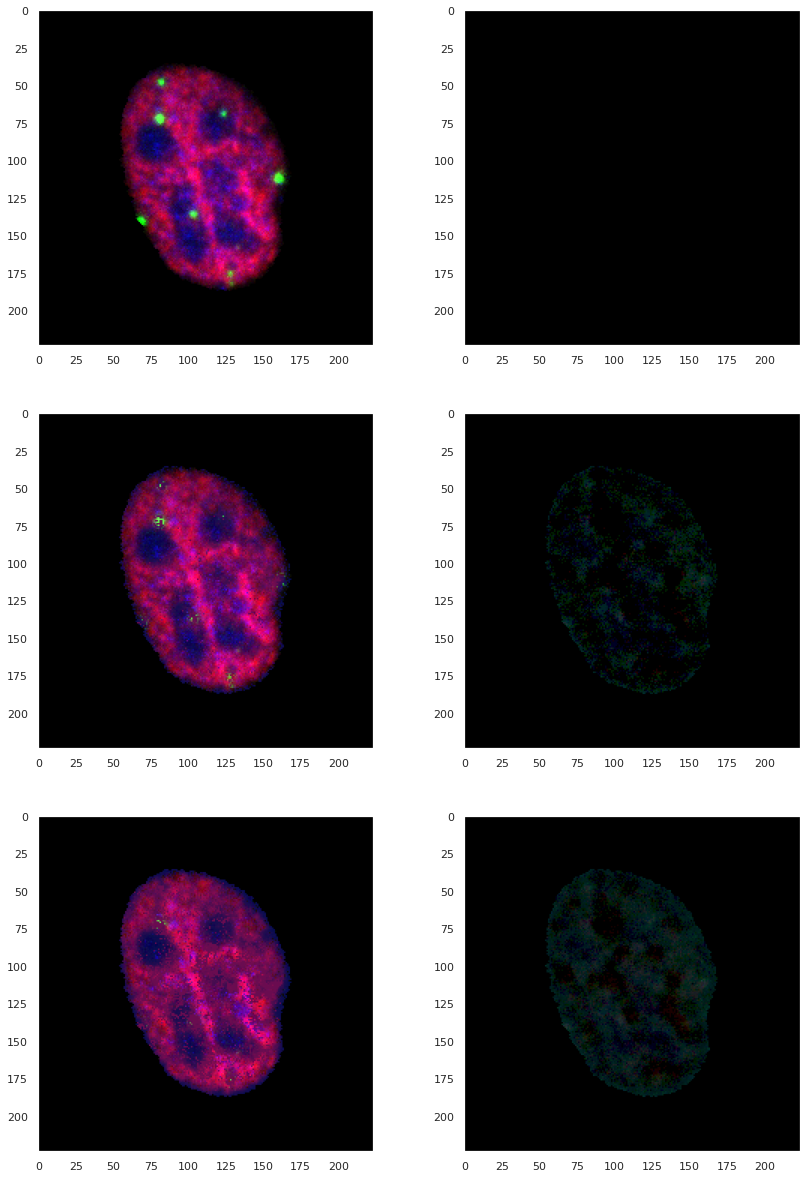

In [29]:
disp_ids = [25, 26,  4]
#disp_ids = [31, 7,  13]
#disp_ids = [31]

for cell_id in sample_ids:
    keys = [key for key in sample_cells.keys() if cell_id in key]
    
    n_rows = len(keys)
    n_columns = 2
    plt.figure(figsize=(2*7,n_rows*7))
    
    plot_count = 0
    for cell_key in keys:
        cell_img = sample_cells[cell_key]
        cell_id = cell_key.split("_")[0]
        score_map = sample_score_maps[cell_id]
        cell_mask = sample_cells_mask[cell_id]
        percent = int(cell_key.split("_")[1]) / 100
        print(percent)
        
        top_score_map = get_top_score_map(score_map, cell_mask, percent)
        #top_score_map = get_top_score_map(score_map, cell_mask, 1)

        # Degradated cell
        plot_count += 1
        plt.subplot(n_rows,n_columns,plot_count)
        plt.imshow(cell_img[:,:,disp_ids],
               cmap=getattr(plt.cm, 'PiYG'),
               #cmap=getattr(plt.cm, 'Blues'),
               aspect='equal',
                )
        plt.grid(False)
        # Top pixels from score map
        plot_count += 1
        plt.subplot(n_rows,n_columns,plot_count)
        plt.imshow(top_score_map[:,:,disp_ids],
                   cmap=getattr(plt.cm, 'Blues'),
                   #cmap=getattr(plt.cm, 'PiYG'),
               aspect='equal',
                )
        plt.grid(False)

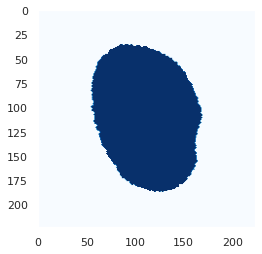

In [66]:
temp_img = sample_cells_mask['337290']
plt.imshow(temp_img,
               #cmap=getattr(plt.cm, 'PiYG'),
               cmap=getattr(plt.cm, 'Blues'),
               aspect='equal',
                )
plt.grid(False)